# Link Adaptation

Link adaptation (LA) is a crucial Layer-2 functionality, optimizing the
performance of a single wireless link by dynamically adjusting the transmission parameters to match the current channel conditions.

The goal of LA is to:
- Maximize the achieved throughput
- While maintaining the block error rate (BLER) sufficiently small

Typically, the problem above is simplified to the following:
- Maintain the BLER close to a predefined target value

where such target value is pre-designed to balance throughput and latency.

In this notebook, we illustrate how to use two state-of-the-art [LA
techniques available in Sionna SYS](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html), namely:
- [Inner-loop link adaptation (ILLA)](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.link_adaptation.InnerLoopLinkAdaptation), which selects the highest modulation and coding scheme (MCS)
  guaranteeing a BLER not exceeding the predefined target value given the current
  channel conditions *estimates*;
- [Outer-loop link adaptation (OLLA)](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.link_adaptation.OuterLoopLinkAdaptation), which exploits HARQ feedback to compensate for non-idealities in channel estimates.

We do so by leveraging the ray-traced channel samples generated by Sionna RT.

## Imports
We start by importing Sionna and the relevant external libraries:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.sys
    import sionna.rt
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Using GPU 0



E0000 00:00:1744143337.419578  250589 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744143337.425419  250589 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744143337.440310  250589 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744143337.440335  250589 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744143337.440337  250589 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744143337.440338  250589 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Additional external libraries
import matplotlib.pyplot as plt
import numpy as np

# Sionna components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, \
    RadioMapSolver, PathSolver, subcarrier_frequencies, Camera
from sionna.phy import config
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, LMMSEPostEqualizationSINR
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.utils import dbm_to_watt, lin_to_db, log2, db_to_lin
from sionna.sys import PHYAbstraction, InnerLoopLinkAdaptation, OuterLoopLinkAdaptation
from sionna.phy.nr.utils import decode_mcs_index

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

# Toggle to False to use the preview widget
# instead of rendering for scene visualization
no_preview = True

I0000 00:00:1744143344.671733  250589 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4715 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


## Simulation parameters

Next, we set the main simulation parameters, common to all our experiments.  
A crucial parameters is the BLER target.
Typical values that strike a good trade-off between throughput and latency are
around 10%.

Note that we assume that the communication occurs in the *downlink* direction between a base
station and a user terminal.

In [3]:
# Number of slots to simulate
num_slots = 500

# BLER target value
bler_target = .1

# Time/frequency resource grid
carrier_frequency = 3.5
num_subcarriers = 1024
subcarrier_spacing = 30e3
num_ofdm_symbols = 13

# MCS table index
mcs_table_index = 1

# 1 base station is considered
num_bs = 1

# Number of antennas at the transmitter and receiver
num_bs_ant = 1
num_ut_ant = 1

# Number of streams per base station
num_streams_per_bs = num_ut_ant

# Base station transmit power
# Low power is sufficient thanks to the lack of interference
bs_power_dbm = 20  # [dBm]
bs_power_watt = dbm_to_watt(bs_power_dbm)

# Noise power per subcarrier
temperature = 294  # [K]
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

In [ ]:
# Transmit power is spread uniformly across subcarriers and streams
tx_power = np.ones(
    shape=[1, num_bs, num_streams_per_bs, num_ofdm_symbols, num_subcarriers])
tx_power *= bs_power_watt / num_streams_per_bs / num_subcarriers

# (Trivial) stream management: 1 user and 1 base station
rx_tx_association = np.ones([1, num_bs])
stream_management = StreamManagement(rx_tx_association, num_streams_per_bs)

# OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_bs,
                             num_streams_per_tx=num_streams_per_bs)

# Subcarrier frequencies, bandwidth ~ 30 MHz
frequencies = subcarrier_frequencies(num_subcarriers=num_subcarriers,
                                     subcarrier_spacing=subcarrier_spacing)

### Generate the channel via Sionna RT

The user mobility is emulated by placing multiple receivers along a straight
line, defined by its start and end points:

In [6]:
# Start/end 3D position of the users
# You can try and change these values to see how the system behaves
ut_pos_start = np.array([-23, -40, 1.5])
ut_pos_end = np.array([-23, 50, 1.5])

# Base station position and look-at direction
bs_pos = np.array([32.5, 10.5, 23])
bs_look_at = np.array([22, -8, 0])

We load a scene to which users and base station are added.

In [7]:
# Load a scene
scene = load_scene(sionna.rt.scene.simple_street_canyon)

# Set the scene parameters
scene.bandwidth = num_subcarriers * subcarrier_spacing
scene.tx_array = PlanarArray(
    num_rows=1, num_cols=num_bs_ant, pattern="tr38901", polarization='V')
scene.rx_array = PlanarArray(
    num_rows=1, num_cols=num_ut_ant, pattern="dipole", polarization='V')

# Add a transmitter to the scene
scene.add(Transmitter("bs", position=bs_pos, look_at=bs_look_at, power_dbm=bs_power_dbm, display_radius=3))

# Emulate moving users by placing multiple receivers along a straight line
step = (ut_pos_end - ut_pos_start) / (num_slots - 1)
# Add users at all future positions at once
for slot in range(num_slots):
    scene.add(Receiver(f"ut{slot}", position=ut_pos_start + slot * step,
                       display_radius=1, color=[0, 0, 0]))

Then, Sionna RT provides the ray-traced channel frequency responses.  
For background on Sionna RT, we refer to the related
[tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html).

In [ ]:
# Configure Sionna RT
p_solver = PathSolver()

# Path solver: Compute propagation paths between the antennas of all
# transmitters and receivers in the scene using ray tracing
paths = p_solver(scene, max_depth=8, refraction=False)

# Transform to channel frequency response (CFR)
# num_slots = number of users
# [num_slots, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                   sampling_frequency=1/resource_grid.ofdm_symbol_duration,
                   num_time_steps=resource_grid.num_ofdm_symbols,
                   out_type="tf")

In [11]:
h_freq.shape

TensorShape([500, 1, 1, 1, 13, 1024])

From the visualization below, we observe that the user moves along a straight line, transitioning from
non-line-of-sight (NLoS) to line-of-sight (LoS) and back to NLoS. 

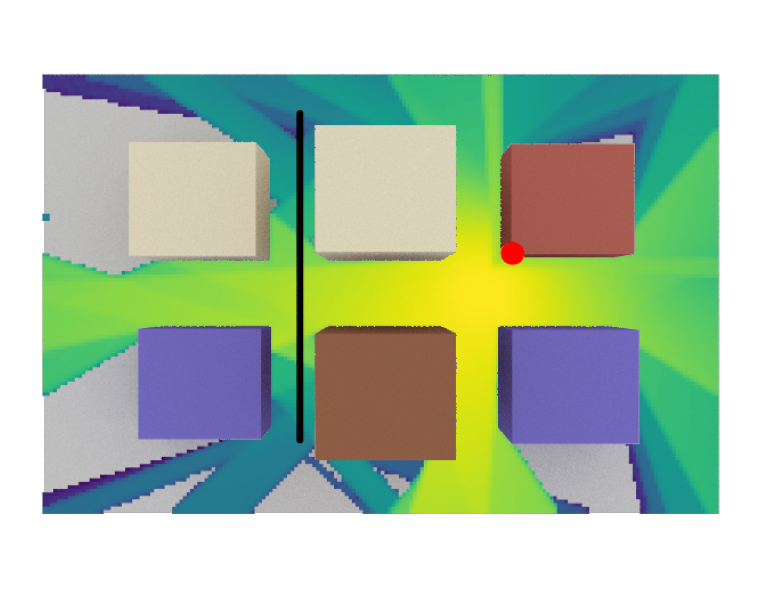

In [10]:
# Compute the Radio Map for the scene and visualize it
rm_solver = RadioMapSolver()
rm = rm_solver(scene, max_depth=8, refraction=False,
               cell_size=(1, 1), samples_per_tx=int(10e6))

if no_preview:
    cam = Camera(position=[0, 0, 250],
                 orientation=np.array([0, np.pi/2, -np.pi/2]))
    scene.render(camera=cam,
                 radio_map=rm,
                 rm_metric="sinr")
else:
    scene.preview(radio_map=rm, rm_metric="sinr")

We will next show how link adaptation selects the MCS in response to
the channel quality variations, while maintaining the BLER close to
the target value. 

## The principles of link adaptation

In its general form, link adaptation (LA) accepts as input:
- Previous HARQ feedback (ACK if the transmission was successful, else NACK);
- Estimated channel conditions;
- Scheduling decisions, to determine the number of coded bits;

and outputs the appropriate modulation
and coding scheme (MCS), where
- Modulation scheme determines the number of
coded bits per symbol;
- Coding scheme defines the coderate.

Note that the HARQ feedback value depends on the MCS index chosen for the last
slot: the more aggressive the MCS, the higher the chance that the codeword is
not correctly decoded, resulting in a negative (NACK) HARQ message. 

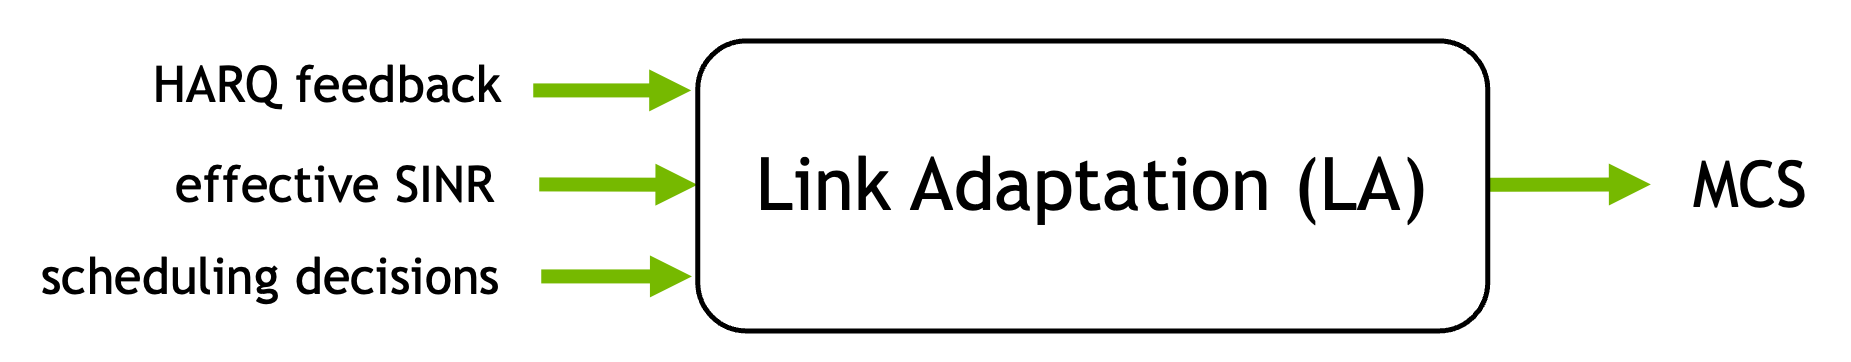

In the following, we will create a layer-2 functionality that 
- Computes the SINR from the input channels;
- Selects the MCS index via a general link adaptation algorithm (We will study
  different choices later on);
- Generates the HARQ feedback via the [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html) functionality.

In [9]:
# Initialize the PHYAbstraction object
phy_abs = PHYAbstraction()

# XLA compile for speed-ups
@tf.function(jit_compile=True)
def la_step(la,
            h,
            sinr_eff_feedback,
            harq_feedback):
    """
    Computes the SINR, select the MCS index, and generate the HARQ feedback for a
    single step of the link adaptation algorithm. 
    """

    # Compute SINR
    # Note that downlink is assumed
    precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management)
    h_eff = precoded_channel(h, tx_power=tx_power, alpha=no)

    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management)

    # [batch_size, num_ofdm_symbols, num_effective_subcarriers, num_rx, num_streams_per_rx]
    sinr = lmmse_posteq_sinr(h_eff, no=no)[0, ...]

    # Number of allocated streams
    num_allocated_re = tf.reduce_sum(
        tf.cast(sinr > 0, tf.int32), axis=[-4, -3, -1])

    # Select MCS index via ILLA
    mcs_index = la(num_allocated_re=num_allocated_re,
                   sinr_eff=sinr_eff_feedback,
                   mcs_table_index=mcs_table_index,
                   mcs_category=1,  # downlink
                   harq_feedback=harq_feedback)

    # Send bits and collect HARQ feedback
    _, harq_feedback, sinr_eff, *_ = phy_abs(
        mcs_index,
        sinr=sinr,
        mcs_table_index=mcs_table_index,
        mcs_category=1)  # downlink

    return mcs_index, harq_feedback, sinr_eff

Next, we write the function for simulating the process defined above over multiple time steps and recording the output.

Note that we offer the option of noisy channel quality estimates.

In [10]:
def run(la,
        noise_feedback=None):
    """
    Calls the link adaptation and physical abstraction blocks over multiple time
    steps and records the history of MCS indices and HARQ feedback.
    Allows for the introduction of noise in the channel estimates.
    """

    # Initialize history
    mcs_index_hist = np.zeros((num_slots))
    harq_feedback_hist = np.zeros((num_slots))
    se_la_hist = np.zeros((num_slots))
    se_shannon_hist = np.zeros((num_slots))
    sinr_eff_db_hist = np.zeros((num_slots))

    # Initialize HARQ feedback to -1 (missing)
    harq_feedback = - tf.cast(1, dtype=tf.int32)

    # Initialize SINR feedback
    sinr_eff_db_true = tf.cast([0], tf.float32)

    for i in range(num_slots):
        # [num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
        h = h_freq[i, ...]
        h = h[tf.newaxis, tf.newaxis, ...]
        # Noisy channel estimate
        if noise_feedback is not None:
            sinr_eff_db_feedback = sinr_eff_db_true + noise_feedback[i]
        else:
            sinr_eff_db_feedback = sinr_eff_db_true

        # Link Adaptation
        mcs_index, harq_feedback, sinr_eff_true = la_step(
            la,
            h,
            sinr_eff_feedback=db_to_lin(sinr_eff_db_feedback),
            harq_feedback=harq_feedback)
        sinr_eff_db_true = lin_to_db(sinr_eff_true)

        # Spectral efficiency
        mod_order, coderate = decode_mcs_index(
            mcs_index,
            table_index=mcs_table_index,
            is_pusch=False)

        if harq_feedback == 1:
            se_la = tf.cast(mod_order, coderate.dtype) * coderate
        else:
            se_la = tf.cast([0], tf.int32)

        # Shannon capacity
        se_shannon = log2(1 + sinr_eff_true)

        # Record history
        mcs_index_hist[i] = mcs_index[0].numpy()
        harq_feedback_hist[i] = harq_feedback[0].numpy()
        se_la_hist[i] = se_la[0].numpy()
        se_shannon_hist[i] = se_shannon[0].numpy()
        sinr_eff_db_hist[i] = sinr_eff_db_true[0].numpy()

    return sinr_eff_db_hist, mcs_index_hist, harq_feedback_hist, \
        se_la_hist, se_shannon_hist

## Inner-Loop Link Adaptation (ILLA)

The simplest form of link adaptation is the so-called [inner-loop link adaptation (ILLA)](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.InnerLoopLinkAdaptation), which selects the
highest MCS whose corresponding BLER does not exceed a predefined BLER target.  

Importantly, ILLA does *not* rely on any feedback loop, such as HARQ feedback, and
fully relies on the estimated channel conditions.

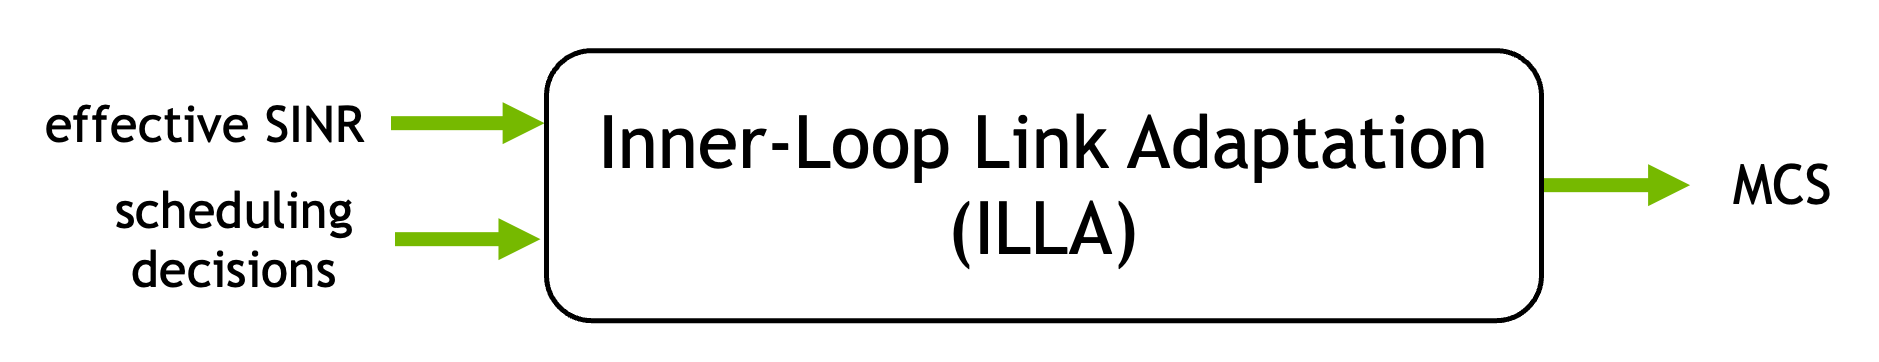

### Perfect channel estimate

Next, we will run ILLA over the ray-traced scenario defined at the beginning of the
notebook.

We assume that the channel estimate is perfect: ILLA observes the true
effective SINR.  
Clearly, this assumption is not realistic and will be lifted later on.

In [11]:
# Initialize the ILLA object
illa = InnerLoopLinkAdaptation(phy_abs,
                               bler_target=bler_target)

# Simulate ILLA over multiple time steps
sinr_eff_db_hist, mcs_illa_ideal, harq_illa_ideal, se_illa_ideal, se_shannon = \
    run(illa)

We can now visualize the results:

In [12]:
def plot(sinr_eff_db_hist, se_la_hist, se_shannon_hist, harq_feedback_hist,
         noise_feedback=None, fig=None, label=None, linestyle='-'):
    is_first_plot = fig is None
    if fig is not None:
        axs = fig.get_axes()
    else:
        fig, axs = plt.subplots(3, 1, sharex='col', sharey='row',
                                figsize=(5, 9))
    if is_first_plot:
        for ax in axs.flat:
            ax.yaxis.set_tick_params(labelleft=True)
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.grid()

    if is_first_plot:
        axs[0].plot(sinr_eff_db_hist, label='true')
        if noise_feedback is not None:
            axs[0].plot(sinr_eff_db_hist + noise_feedback,
                        ':', label='noisy feedback')
        axs[0].set_ylabel('SINR [dB]')
        axs[0].set_xlabel('Slot')
        axs[0].legend()

    axs[1].plot(se_la_hist[:], linestyle=linestyle, label=label)
    if is_first_plot:
        axs[1].plot(se_shannon_hist, '--k', label='Shannon capacity')
    axs[1].set_ylabel('Spectral efficiency [bps/Hz]')
    axs[1].set_xlabel('Slot')
    axs[1].legend()

    if is_first_plot:
        axs[2].plot([0, num_slots - 1], [bler_target]
                    * 2, '--k', label='BLER target')
    axs[2].plot(1 - np.cumsum(harq_feedback_hist) / np.arange(1, num_slots + 1),
                linestyle=linestyle, label=label)
    axs[2].set_ylabel('Achieved BLER')
    axs[2].set_xlabel('Slot')
    axs[2].legend()
    fig.tight_layout()
    return fig, axs

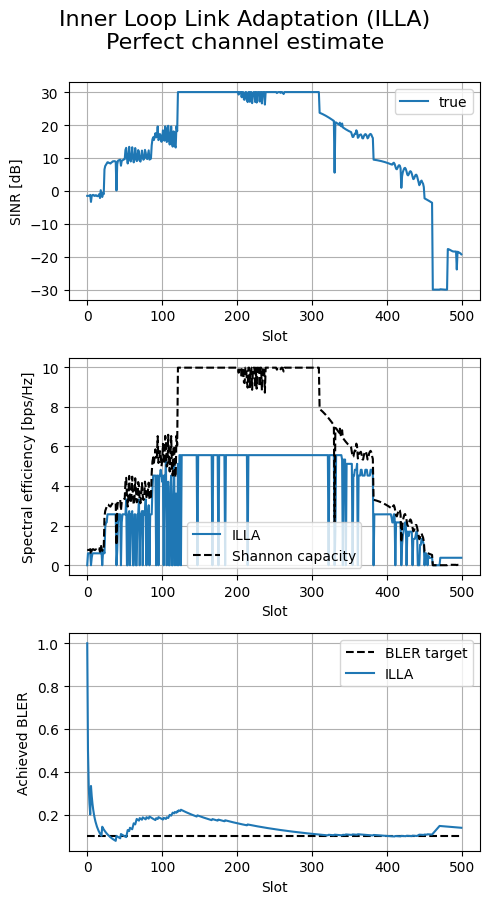

In [13]:
fig, axs = plot(sinr_eff_db_hist, se_illa_ideal,
                se_shannon, harq_illa_ideal, label='ILLA')
fig.suptitle('Inner Loop Link Adaptation (ILLA)\nPerfect channel estimate',
             fontsize=16, y=1)
fig.tight_layout()
plt.show()

Note that the MCS evolution follows closely the one of the effective SINR: the higher
the SINR, the higher the supported MCS index, hence the higher the spectral efficiency.

Moreover, the BLER is fairly close to the target.

However, the perfect channel estimate assumption is unrealistic: In real
systems, the channel estimate is noisy and performed intermittently over time.


### Imperfect channel estimation

We now address a more realistic scenario, where the channel estimates are noisy.
We will observe that ILLA struggles in this scenario.

In [14]:
noise_feedback_std = 1.5
noise_feedback = config.tf_rng.normal(
    shape=[num_slots], dtype=tf.float32, stddev=noise_feedback_std)

# Simulate ILLA over multiple time steps
sinr_eff_db_hist, mcs_illa_noisy, harq_illa_noisy, se_illa_noisy, se_shannon = \
    run(illa, noise_feedback=noise_feedback)

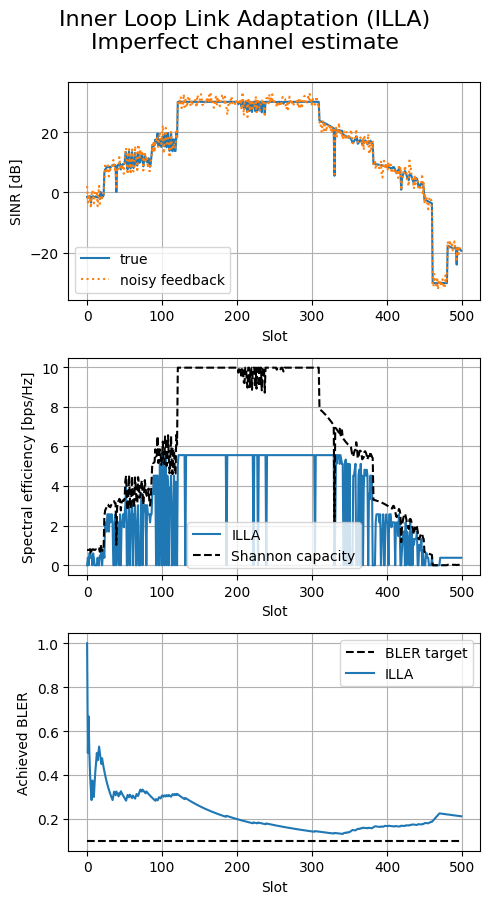

In [15]:
fig, axs = plot(sinr_eff_db_hist, se_illa_noisy, se_shannon,
                harq_illa_noisy, noise_feedback=noise_feedback, label='ILLA')
fig.suptitle('Inner Loop Link Adaptation (ILLA)\nImperfect channel estimate',
             fontsize=16, y=1)
fig.tight_layout()
plt.show()

In the presence of noisy channel estimates, ILLA is no longer able to maintain
the BLER close to the target value.

This is expected: ILLA fully relies on the provided estimates and does not even
attempt to adjust its behavior based on the achieved BLER.

To this aim, a feedback-driven outer-loop is introduced in the following.

## Outer-Loop Link Adaption (OLLA)

In contrast to ILLA, the [outer-loop link adaptation (OLLA)](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.OuterLoopLinkAdaptation) algorithm (see [[1]](#references)) introduces
a simple closed-loop mechanism that adjust its behavior based on the HARQ
feedback. This is realized by introducing an offset value applied to the effective SINR
estimate, which varies according to the observed HARQ feedback.  
Such a simple and effective mechanism enables the BLER to converge asymptotically to
the predefined target value.

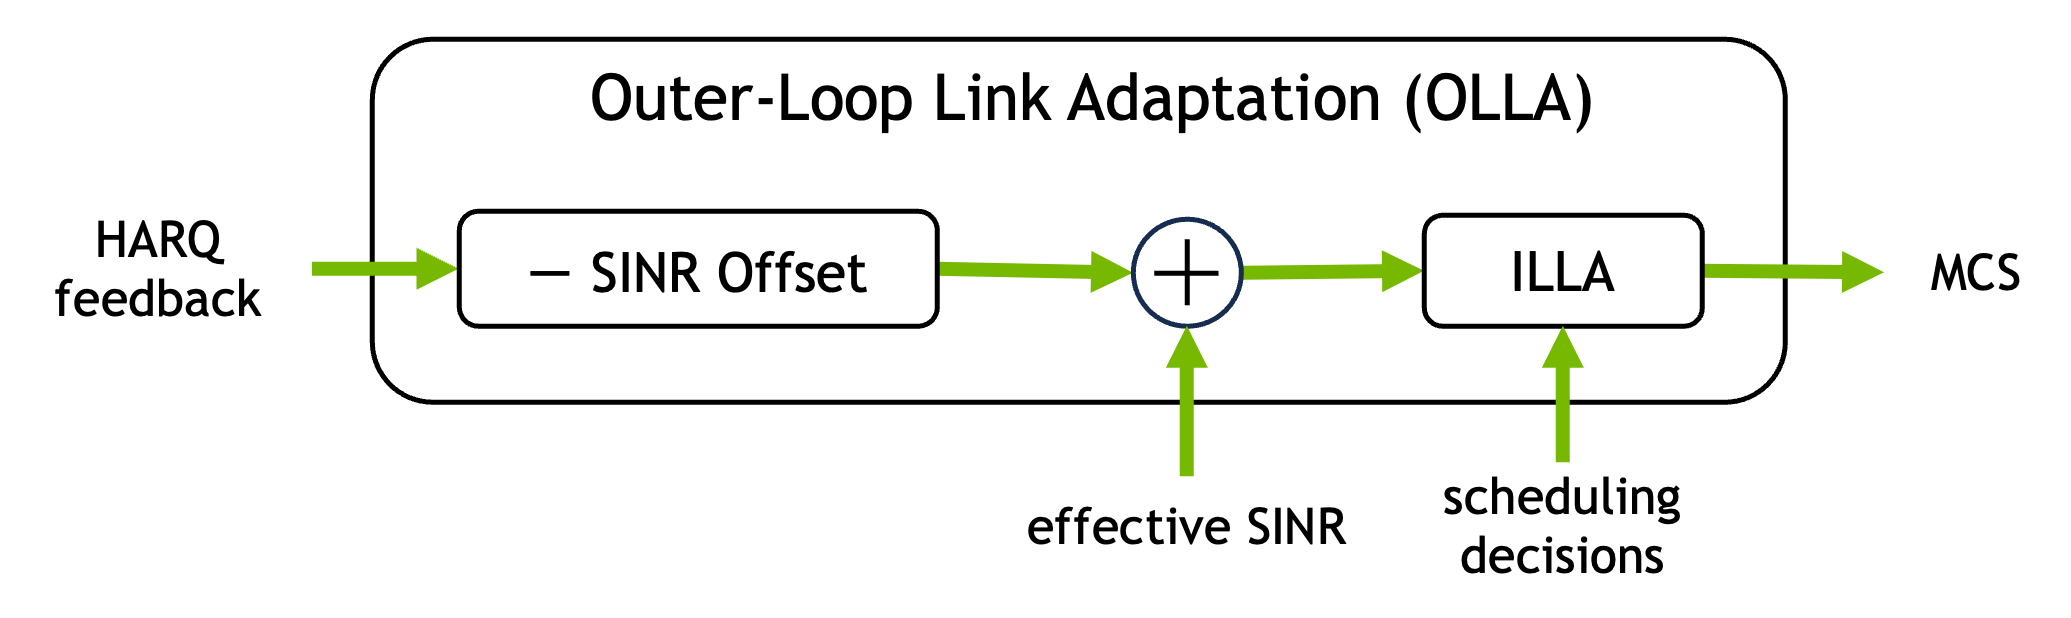

In [16]:
# Instantiate an OLLA object
olla = OuterLoopLinkAdaptation(phy_abs,
                               num_ut=1,
                               bler_target=bler_target)

After instantiating the OLLA object, we can now run OLLA across multiple time
steps on the ray-traced scenario defined at the beginning of the notebook.

In [17]:
sinr_eff_db_hist, mcs_olla, harq_olla, se_olla, se_shannon = \
    run(olla, noise_feedback=noise_feedback)

Finally, we visualize the results and compare them with ILLA.

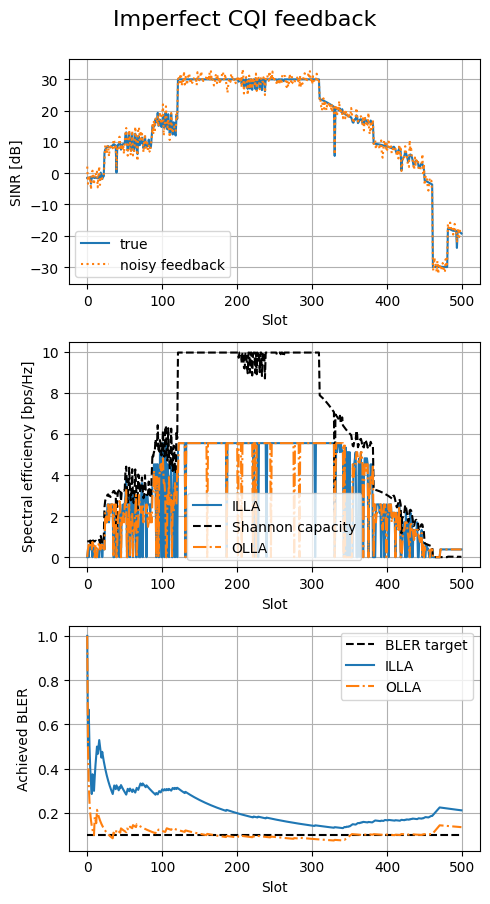

In [18]:
fig, axs = plot(sinr_eff_db_hist, se_illa_noisy, se_shannon, harq_illa_noisy,
                noise_feedback=noise_feedback, label='ILLA')
fig.suptitle('Inner Loop Link Adaptation (ILLA)\nImperfect channel estimate',
             fontsize=16, y=1)
fig, axs = plot(sinr_eff_db_hist, se_olla, se_shannon, harq_olla,
                noise_feedback=noise_feedback, fig=fig, label='OLLA', linestyle='-.')
fig.suptitle('Imperfect CQI feedback',
             fontsize=16, y=1)
fig.tight_layout()
plt.show()

We observe that OLLA succeeds in maintaining the BLER close to the target value,
although the channel estimates are noisy.  

This occurs thanks to the closed-loop mechanism that adjusts the effective SINR
according to the observed HARQ feedback.

## Conclusions

The [OuterLoopLinkAdaptation](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.OuterLoopLinkAdaptation)
(OLLA) class adjusts the MCS index to maintain a
target BLER.  
By applying a feedback loop that adjusts the SINR estimate based on the
observed BLER, OLLA is resilient to noisy channel quality feedback.  
In contrast,
[InnerLoopLinkAdaptation](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.InnerLoopLinkAdaptation)
(ILLA) lacks this robustness but serves as a key subroutine within OLLA.


## References

[1] K. I. Pedersen, G. Monghal, I. Z. Kovacs, T. E. Kolding, A. Pokhariyal, F.
Frederiksen, P. Mogensen. "Frequency domain scheduling for OFDMA with limited
and noisy channel feedback."," 2007 IEEE 66th Vehicular Technology Conference,
pp. 1792-1796, 2007.  